In [1]:
from google.colab import drive
drive.mount("/content/drive")

import seaborn as sns
import numpy as np
import pandas as pd
from scipy.integrate import odeint
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy import optimize
import pickle
import statsmodels.api as sm


Mounted at /content/drive


/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [6]:
import torch
from torch import nn, optim
from torch.autograd import Variable
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

In [7]:
def create_sequences(data, seq_length):
    xs = []
    ys = []

    for i in range(len(data)-seq_length-1):
        x = data[i:(i+seq_length)]
        y = data[i+seq_length]
        xs.append(x)
        ys.append(y)

    return np.array(xs), np.array(ys)

In [8]:
hos_data = pickle.load( open( "/content/drive/My Drive/ISE599Project_Phebe/Data/new_hospitalized_data.p", "rb" ) )
hos_data_alhambra = hos_data[hos_data['geo_merge']=='Alhambra']
dates = [pd.to_datetime(i) - pd.to_datetime('2020-02-01')  for i in hos_data_alhambra['ep_date']]
dates = [i.days for i in dates]
dates = pd.Series(dates,index=hos_data_alhambra.index)
hos_data_alhambra['dates']=dates
hos_data_alhambra = hos_data_alhambra.sort_values(by=['dates'])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [9]:
daily_cases = hos_data_alhambra['hosp_14day'] 

test_data_size = 250
len_train = 30
forecast_len = 30 

train_data = daily_cases[:-test_data_size]
test_data = daily_cases[-test_data_size:]
train_data = np.expand_dims(train_data, axis=1)
test_data = np.expand_dims(test_data, axis=1)


In [10]:
seq_length = len_train 

X_train, y_train = create_sequences(train_data, seq_length)
X_test, y_test = create_sequences(test_data, seq_length)

X_train = torch.from_numpy(X_train).float()
y_train = torch.from_numpy(y_train).float()

X_test = torch.from_numpy(X_test).float()
y_test = torch.from_numpy(y_test).float()

In [16]:
y_train.shape,X_train.shape,y_test.shape,X_test.shape

(torch.Size([452, 1]),
 torch.Size([452, 30, 1]),
 torch.Size([219, 1]),
 torch.Size([219, 30, 1]))

In [23]:
len(X_train)

452

In [21]:
#Create testing sequence
y_true = y_train.data.numpy()
y_calb = np.zeros((len(y_true)-forecast_len,forecast_len))
for i in range(len(y_true)-forecast_len):
    y_calb[i] = y_true[i:i+forecast_len].reshape(forecast_len,)

In [22]:
y_calb

array([[ 6.,  6.,  7., ..., 12., 12., 12.],
       [ 6.,  7.,  8., ..., 12., 12., 12.],
       [ 7.,  8.,  8., ..., 12., 12., 14.],
       ...,
       [ 5.,  5.,  6., ...,  6.,  6.,  6.],
       [ 5.,  6.,  6., ...,  6.,  6.,  5.],
       [ 6.,  6.,  7., ...,  6.,  5.,  5.]])

In [ ]:
DF = pd.read_pickle('/content/drive/My Drive/ISE599Project_Phebe/Data/new_hospitalized_data.p')
list(DF.columns)
DF.head()

,Unnamed: 0,ep_date,geo_merge,hosp_14day,hosp_14day_rate,adj_hosp_14day_rate,hosp_rate_unstable,population,zip0,zip1,...,zip10,pop65,pop,med_income,mean_income,male,white,black,asian,hispanic
0,1,3/3/2022,Agoura Hills,0,0,0,NaN,20883,91301.0,0.0,...,0.0,4322.0,25488.0,124012.0,181113.0,12929.0,21756.0,718.0,1934.0,26334.0
1,2,3/3/2022,Alhambra,3,3,3,^,86724,91801.0,91803.0,...,0.0,15135.0,83057.0,123783.0,171425.0,40984.0,19360.0,1894.0,43022.0,84335.0
2,3,3/3/2022,Arcadia,3,5,4,^,57754,91006.0,91007.0,...,0.0,13282.0,65810.0,187188.0,250499.0,31970.0,19717.0,1243.0,40201.0,67074.0
3,4,3/3/2022,Artesia,0,0,0,NaN,16795,90701.0,0.0,...,0.0,2575.0,16591.0,67765.0,83874.0,7886.0,4735.0,850.0,6191.0,16801.0
4,5,3/3/2022,Avalon,0,0,0,NaN,3869,90704.0,0.0,...,0.0,603.0,4090.0,73287.0,88731.0,1998.0,3243.0,4.0,17.0,3979.0


There are many NaN in the dataframe.

In [ ]:
# DF.isna().sum().sum()
# DF = DF[DF['ep_date'].notna()]

In [ ]:
# selecting rows based on condition
#DF = DF[DF['hosp_rate_unstable'].notna()]

In [ ]:
Location = pd.unique(DF['geo_merge'])
Loc1 = DF.loc[DF['geo_merge'] ==Location[1]] # data filtered for one location
Location.shape

(312,)

There is 312 locations. 

In [ ]:
import datetime
Date = pd.unique(Loc1['ep_date'])
dates = [datetime.datetime.strptime(ts, "%m/%d/%Y") for ts in Date]
dates.sort()
sorteddates = [datetime.datetime.strftime(ts, "%m/%d/%Y") for ts in dates]
print("This data set contains data from",sorteddates[1],"to",sorteddates[-1])

This data set contains data from 03/02/2020 to 03/03/2022


There were duplicate results at the same place and day. 

In [ ]:
values, counts = np.unique(Loc1['ep_date'], return_counts=True)
data = {'value' : values,
        'counts' : counts}
# Check whether there is duplicate data
UniqueData = pd.DataFrame(data)
UniqueData

,value,counts
0,1/1/2021,1
1,1/1/2022,1
2,1/10/2021,1
3,1/10/2022,1
4,1/11/2021,1
...,...,...
728,9/7/2021,1
729,9/8/2020,1
730,9/8/2021,1
731,9/9/2020,1


In [ ]:
# test for how to combine data of one day
A = Loc1.loc[Loc1['ep_date'] =="1/1/2022", 'hosp_14day'].sum()
B = Loc1.loc[Loc1['ep_date'] ==UniqueData.value[1], 'hosp_14day'].sum()
Loc1.loc[Loc1['ep_date'] ==UniqueData.value[1],]


,Unnamed: 0,ep_date,geo_merge,hosp_14day,hosp_14day_rate,adj_hosp_14day_rate,hosp_rate_unstable,population,zip0,zip1,...,zip10,pop65,pop,med_income,mean_income,male,white,black,asian,hispanic
20192,20193,1/1/2022,Alhambra,23,27,21,NaN,86724,91801.0,91803.0,...,0.0,15135.0,83057.0,123783.0,171425.0,40984.0,19360.0,1894.0,43022.0,84335.0


In [ ]:
Loc1_Sum = []
Loc1_date = []
for i in range(UniqueData.shape[0]):    
    Loc1_Sum.append(Loc1.loc[Loc1['ep_date'] ==UniqueData.value[i], 'hosp_14day'].sum())
    Loc1_date.append(UniqueData.value[i])

d = {'ep_date':Loc1_date,
     'hosp_14day':Loc1_Sum}
Loc1S = pd.DataFrame(data = d)
  

Loc1S['ep_date'] = pd.to_datetime(Loc1S['ep_date'])


In [ ]:
Loc1S = Loc1S.sort_values(by='ep_date')
Loc1S.index = range(len(Loc1S))
Loc1S
# # set the index to be the date
# Loc1S['ep_date'] = pd.to_datetime(Loc1S['ep_date'] )
# Loc1S = Loc1S.set_index('ep_date')

,ep_date,hosp_14day
0,2020-03-01,0
1,2020-03-02,0
2,2020-03-03,0
3,2020-03-04,0
4,2020-03-05,0
...,...,...
728,2022-02-27,6
729,2022-02-28,5
730,2022-03-01,5
731,2022-03-02,3


In [ ]:
def plot_df(df, x, y, title="", xlabel='Date', ylabel='Value', dpi=100):
    plt.figure(figsize=(16,5), dpi=dpi)
    plt.plot(x, y, color='tab:red')
    plt.gca().set(title=title, xlabel=xlabel, ylabel=ylabel)
    plt.show()

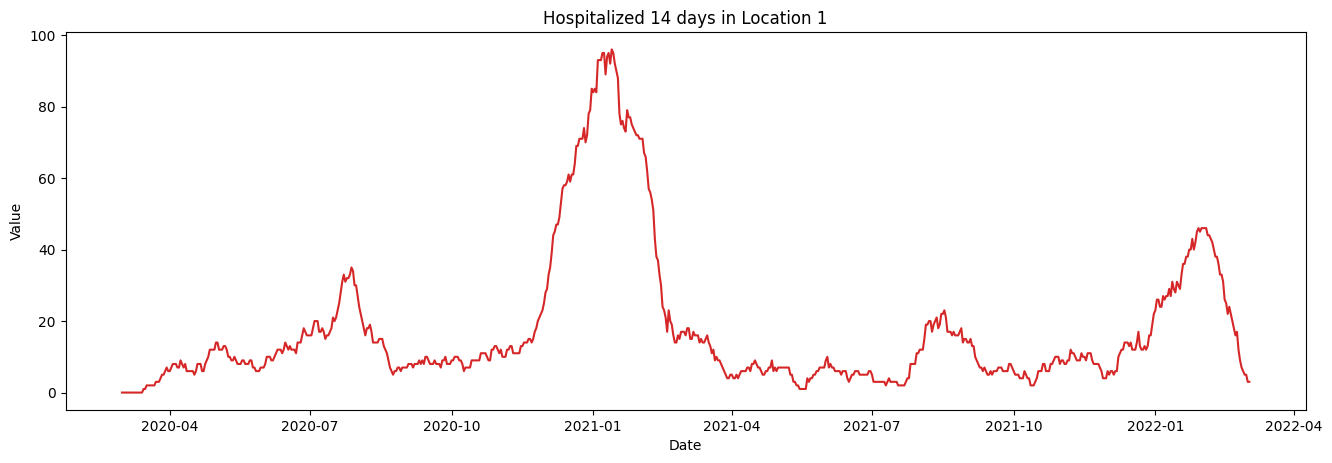

In [ ]:
plot_df(Loc1S, x=Loc1S.ep_date, y=Loc1S.hosp_14day, title='Hospitalized 14 days in Location 1')    

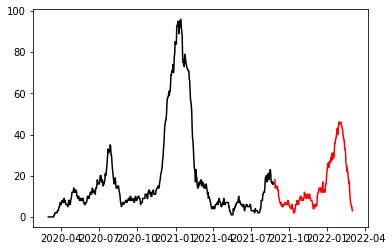

,ep_date,hosp_14day
0,2020-03-01,0
1,2020-03-02,0
2,2020-03-03,0
3,2020-03-04,0
4,2020-03-05,0
...,...,...
539,2021-08-22,16
540,2021-08-23,17
541,2021-08-24,16
542,2021-08-25,16


In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

train = Loc1S[Loc1S.ep_date < UniqueData.value[650]]
test = Loc1S[Loc1S.ep_date > UniqueData.value[650]]
train.index = range(len(train.index))
test.index = range(len(test.index))


plt.plot(train.ep_date, train.hosp_14day, color = "black")
plt.plot(test.ep_date, test.hosp_14day, color = "red")
plt.show()
train

ARMA model

In [ ]:
y = train.hosp_14day
ARMAmodel = SARIMAX(y, order = (1, 0, 1))
ARMAmodel = ARMAmodel.fit()
y_pred = ARMAmodel.get_forecast(len(test.index))
y_pred_df = y_pred.conf_int(alpha = 0.05) 
y_pred_df["Predictions"] = ARMAmodel.predict(start = y_pred_df.index[0], end = y_pred_df.index[-1])
y_pred_df.index = test.index
y_pred_out = y_pred_df["Predictions"] 

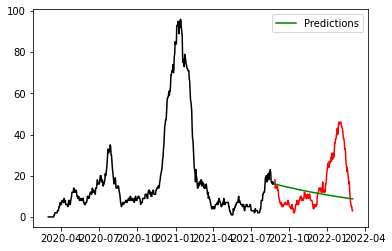

In [ ]:
plt.plot(train.ep_date, train.hosp_14day, color = "black")
plt.plot(test.ep_date, test.hosp_14day, color = "red")
plt.plot(test.ep_date,y_pred_out, color='green', label = 'Predictions')
plt.legend()
plt.show()

In [ ]:
SARIMAXmodel = SARIMAX(y, order = (5, 4, 2), seasonal_order=(2,2,2,12))
SARIMAXmodel = SARIMAXmodel.fit()


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:961: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:993: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


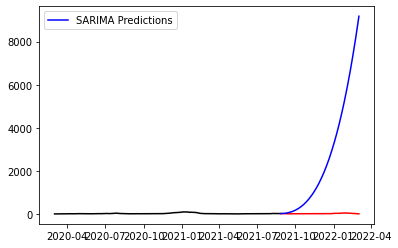

In [ ]:
y_pred = SARIMAXmodel.get_forecast(len(test.index))
y_pred_df = y_pred.conf_int(alpha = 0.05) 
y_pred_df["Predictions"] = SARIMAXmodel.predict(start = y_pred_df.index[0], end = y_pred_df.index[-1])
y_pred_df.index = test.index
y_pred_out = y_pred_df["Predictions"] 
plt.plot(train.ep_date, train.hosp_14day, color = "black")
plt.plot(test.ep_date, test.hosp_14day, color = "red")
plt.plot(test.ep_date,y_pred_out, color='Blue', label = 'SARIMA Predictions')
plt.legend()

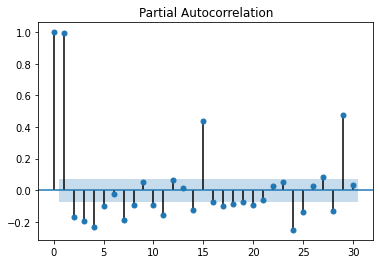

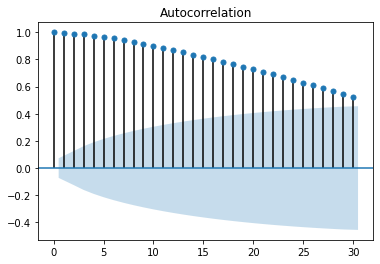

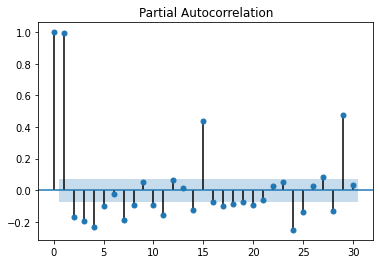

In [ ]:
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_acf(Loc1S.hosp_14day.tolist(), lags=30)
plot_pacf(Loc1S.hosp_14day.tolist(), lags=30)

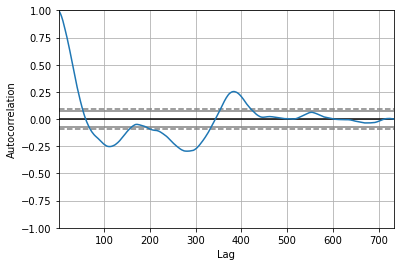

In [ ]:
from pandas.plotting import autocorrelation_plot
autocorrelation_plot(Loc1S.hosp_14day.tolist())

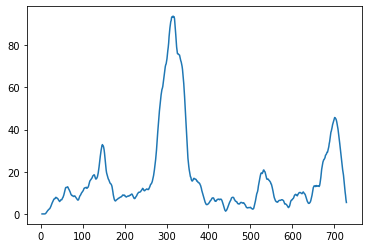

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose
result_mul = seasonal_decompose(Loc1S['hosp_14day'], freq=7)
detrended = Loc1S.hosp_14day.values - result_mul.trend
plt.plot(result_mul.trend)
plt.show()

0     -0.000573
1     -0.004694
2     -0.013043
3      0.006295
4     -0.001947
         ...   
728   -0.000573
729   -0.004694
730   -0.013043
731    0.006295
732   -0.001947
Name: hosp_14day, Length: 733, dtype: float64

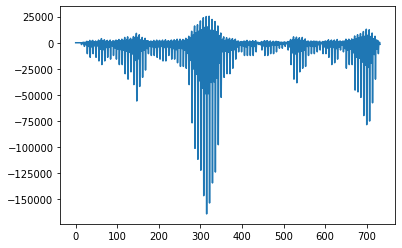

In [ ]:
# from statsmodels.tsa.seasonal import seasonal_decompose
# from dateutil.parser import parse
# # Time Series Decomposition
# result_mul = seasonal_decompose(Loc1S['hosp_14day'], model='multiplicative', extrapolate_trend='freq')

# Deseasonalize
deseasonalized = Loc1S.hosp_14day.values / result_mul.seasonal

# Plot
plt.plot(deseasonalized)
plt.plot()
res_test = result_mul.seasonal[range(len(train),len(Loc1S.hosp_14day))]
result_mul.seasonal

/usr/local/lib/python3.7/dist-packages/statsmodels/regression/linear_model.py:1358: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


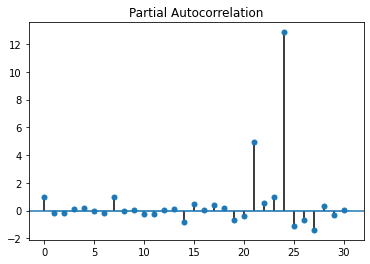

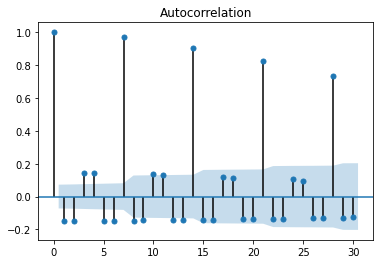

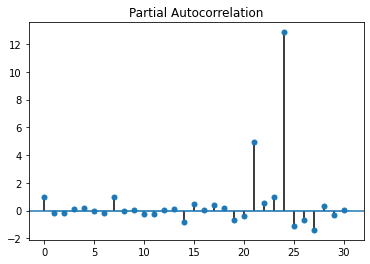

In [ ]:
plot_acf(deseasonalized.tolist(), lags=30)
plot_pacf(deseasonalized.tolist(), lags=30)

In [ ]:
y = deseasonalized
ARMAmodel = SARIMAX(y, order = (5, 2, 7))
ARMAmodel = ARMAmodel.fit()
y_pred = ARMAmodel.get_forecast(len(test.index))
y_pred_df = y_pred.conf_int(alpha = 0.05) 
y_pred_df["Predictions"] = ARMAmodel.predict(start = y_pred_df.index[0], end = y_pred_df.index[-1])
y_pred_df.index = test.index
y_pred_out = y_pred_df["Predictions"] 

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:961: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


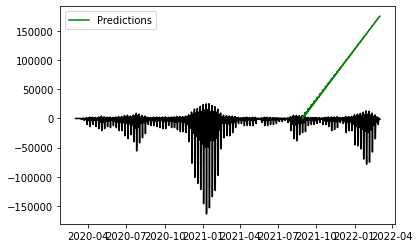

In [ ]:
plt.plot(Loc1S.ep_date, y, color = "black")
plt.plot(test.ep_date,y_pred_out, color='green', label = 'Predictions')
plt.legend()
plt.show()